## Generate NUM_PATIENTS cases for training (2 labels: No hemorrhage and Most occurrence hemorrhage type)

In [1]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

## Config

In [2]:
# Define storage location and dataset name
storage = 'E:/'
dataset_name = 'rsna-intracranial-hemorrhage-detection'

# Construct paths
dataset_path = os.path.join(storage, dataset_name)
dataset_output_name = 'rsna-mil-training'
destination_dir = os.path.join('D:/', dataset_output_name)
train_images_dir = os.path.join(dataset_path, 'stage_2_train')
sorted_training = 'C:/Users/MINH/OneDrive - nhatminhtrieu/Thesis 2025 Storage/RSNA_Datasheet/sorted_training_dataset_with_labels.csv'

# Define hemorrhage types
hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

# Set number of patients
NUM_PATIENTS = 1000

random_state = 42

os.makedirs(destination_dir, exist_ok=True)

In [3]:
# Read file csv as a dataframe
raw_df = pd.read_csv(sorted_training)

In [4]:
raw_df.head(1)

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,ID
0,ID_45785016b.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 35.968]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,45785016b


In [5]:
raw_df.columns

Index(['filename', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'patient_id', 'study_instance_uid',
       'series_instance_uid', 'image_position', 'samples_per_pixel',
       'pixel_spacing', 'pixel_representation', 'window_center',
       'window_width', 'rescale_intercept', 'rescale_slope', 'ID'],
      dtype='object')

## Create dataframe

In [6]:
def process_medical_images(raw_df):
    grouped = raw_df.groupby(['patient_id', 'study_instance_uid'])
    
    metadata_columns = ['image_position', 'samples_per_pixel', 'pixel_spacing', 'pixel_representation', 
                        'window_center', 'window_width', 'rescale_intercept', 'rescale_slope', 'ID']
    
    label_columns = hemorrhage_types
    
    new_df_list = [
        {
            'patient_id': patient_id,
            'study_instance_uid': study_instance_uid,
            'images': group['filename'].tolist(),
            'labels': [int(any(row)) for row in group[label_columns].values],
            'patient_scan_label': int(group['any'].any()),
            'metadata': group[metadata_columns].to_dict('records')
        }
        for (patient_id, study_instance_uid), group in grouped
    ]
    
    new_df = pd.DataFrame(new_df_list)
    return new_df[['patient_id', 'study_instance_uid', 'images', 'labels', 'patient_scan_label', 'metadata']]

### Balancing labels

In [7]:
def balanced_patient_sample(df, max_size=None):
    # Process the raw DataFrame to get the main DataFrame
    processed_df = process_medical_images(df)
    
    # Filter patients based on the number of labeled images
    patients_with_0_labels = processed_df[processed_df['patient_scan_label'] == 0]
    patients_with_1_label = processed_df[processed_df['patient_scan_label'] == 1]
    
    # Determine the number of samples to take from each group
    if max_size is not None:
        num_samples = max_size // 2
    else:
        num_samples = min(len(patients_with_0_labels), len(patients_with_1_label))
    
    # Ensure we do not exceed available samples
    sampled_0_labels = patients_with_0_labels.sample(n=min(num_samples, len(patients_with_0_labels)), random_state=random_state)
    sampled_1_label = patients_with_1_label.sample(n=min(num_samples, len(patients_with_1_label)), random_state=random_state)
    
    # Concatenate the two sampled DataFrames
    balanced_df = pd.concat([sampled_0_labels, sampled_1_label], ignore_index=True)

    return balanced_df

### Save dataframe

In [8]:
balanced_patients_df = balanced_patient_sample(raw_df, max_size=NUM_PATIENTS)

In [9]:
balanced_patients_df.head()

,patient_id,study_instance_uid,images,labels,patient_scan_label,metadata
0,ID_2e010e33,ID_bda0f47e84,"[ID_b9035cb1e.dcm, ID_0713bed86.dcm, ID_5c1a61...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-125.000, -106.498, 42.7..."
1,ID_43dd2890,ID_43af13416f,"[ID_23864d3ba.dcm, ID_f1c65b76e.dcm, ID_5a822b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-114.5, 25.5, 86.9000244..."
2,ID_93753256,ID_1ee74896bd,"[ID_a3a37df48.dcm, ID_61dd5485f.dcm, ID_930ea8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-125, -11, 119.599976]',..."
3,ID_2d49911c,ID_a71e7c6817,"[ID_93d9cf661.dcm, ID_efd4e2780.dcm, ID_7f6bed...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-125.000, -153.258, 47.6..."
4,ID_cd2cd174,ID_d02e9abf35,"[ID_b437d2e19.dcm, ID_0a919428c.dcm, ID_d3cd41...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-110.5, -15.5, 103.80004..."


In [10]:
# Save the extracted patients to a new CSV file
balanced_patients_df.to_csv(f'{destination_dir}/training_{len(balanced_patients_df)}_scan_subset.csv', index=False)

## Save DICOM images

In [11]:
def group_dcm_files(images_dir, df, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)  # Create the main destination directory
    folder_dict = {}

    # Precompute folder paths to reduce repeated calls to os.makedirs()
    for index, row in df.iterrows():
        patient_id = row['patient_id'].replace('ID_', '')
        study_instance_uid = row['study_instance_uid'].replace('ID_', '')
        folder_name = f'{patient_id}_{study_instance_uid}'
                
        # Store folder path if it doesn't exist
        if folder_name not in folder_dict:
            folder_path = os.path.join(destination_dir, folder_name)
            os.makedirs(folder_path, exist_ok=True)  # Create the directory only once
            folder_dict[folder_name] = folder_path
        
        images = row['images']  # Expecting images is a list
        for image in images:
            image_path = os.path.join(images_dir, image)
            if os.path.isfile(image_path):  # Check if file exists before copying
                shutil.copy(image_path, folder_dict[folder_name])  # Use precomputed path
            else:
                print(f'Warning: {image} not found in {images_dir}.')  # Handle missing files

In [12]:
group_dcm_files(images_dir=train_images_dir, df=balanced_patients_df, destination_dir=destination_dir)

## Statistics

In [13]:
def analyze_patient_data(data):
    # Drop the metadata column for analysis
    data_analysis = data.drop(columns=['metadata'])

    # Example Analysis: Distribution of labels
    label_counts = pd.Series([label for sublist in data_analysis['labels'] for label in sublist]).value_counts()

    # Plotting the distribution of labels
    plt.figure(figsize=(10, 6))
    bars = label_counts.plot(kind='bar')
    plt.title('Distribution of Labels')
    plt.xlabel('Label Value')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Adding value labels on top of each bar
    for bar in bars.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')

    plt.show()

    # Calculate the number of images per patient
    data_analysis['num_images'] = data_analysis['images'].apply(len)  # Directly get length of list

    # Calculate max, min, mean
    max_images = data_analysis['num_images'].max()
    min_images = data_analysis['num_images'].min()
    mean_images = data_analysis['num_images'].mean()

    # Plotting max, min, mean number of images
    plt.figure(figsize=(8, 5))
    plt.bar(['Max', 'Min', 'Mean'], [max_images, min_images, mean_images], color=['red', 'blue', 'green'])
    plt.title('Max, Min, Mean Number of Images per Patient')
    plt.ylabel('Number of Images')
    plt.ylim(0, max(max_images + 1, mean_images + 1))  # Set y-limit to be slightly above max value

    for index, value in enumerate([max_images, min_images, mean_images]):
        plt.text(index, value + 0.1, str(value), ha='center')

    plt.tight_layout()
    plt.show()

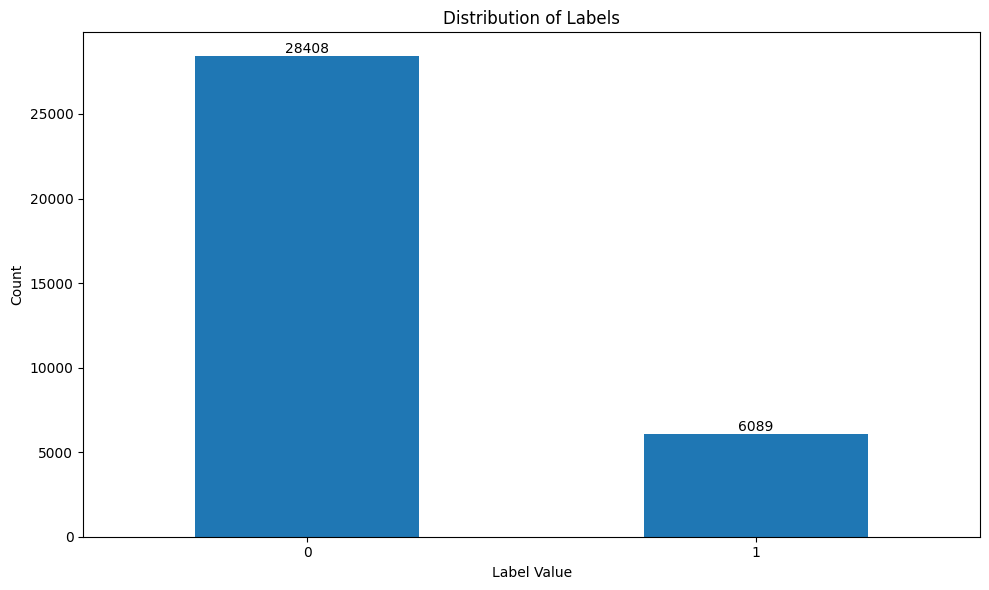

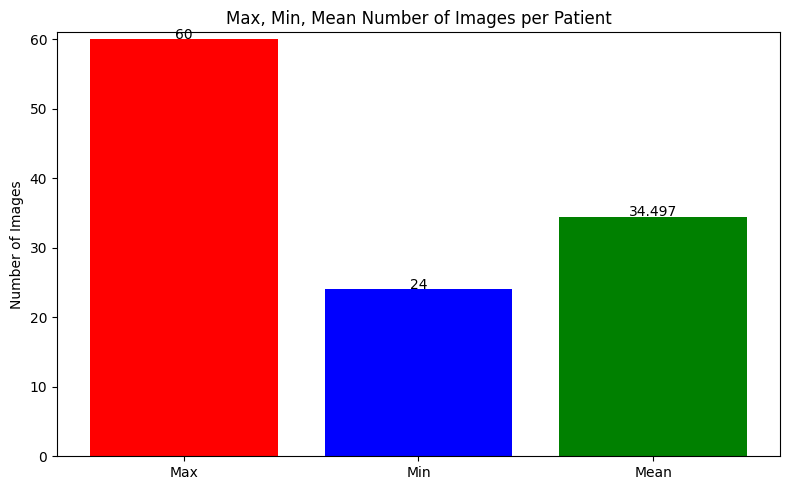

In [14]:
analyze_patient_data(balanced_patients_df)